In [197]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from sklearn.model_selection import train_test_split
import keras
keras.utils.set_random_seed(42)
from sklearn.metrics import accuracy_score
keras =tf.keras
from keras.optimizers import Adam

In [198]:
def fill_missing_data_with_mice_imputer(df: pd.DataFrame):
        mice_imputer_df = df.copy()

        mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None,
                                        imputation_order='ascending')

        df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(mice_imputer_df), columns=mice_imputer_df.columns)

        return df_mice_imputed

In [199]:
def hot_encode_columns(original_df, columns):
    original_df = original_df.copy()
    
    print([*columns])
    encoded_df = pd.get_dummies(original_df.loc[:, columns])

    original_df = original_df.drop([*columns] , axis = 1) 
    return pd.concat([original_df,encoded_df], axis=1)
    

In [200]:
## SHow missing values

def show_missing_values(df: pd.DataFrame):
    

    fig, ax = plt.subplots(figsize=(20, 6))
    
    
    sns.heatmap(df.isnull(), cbar=False, ax=ax)
    
    
    plt.show()

In [201]:
train_df = pd.read_csv('./data/train.csv')

test_df = pd.read_csv('./data/test.csv')

In [202]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [203]:
columns_to_drop = ['Name', 'Cabin' , 
                        'Ticket']

train_df = train_df.drop(columns_to_drop, axis=1)

test_df = test_df.drop(columns_to_drop, axis=1)

In [204]:
columns_to_encode =['Sex'  , 'Embarked']

In [205]:
train_df = hot_encode_columns(train_df , columns_to_encode)

['Sex', 'Embarked']


In [206]:
test_df = hot_encode_columns(test_df , columns_to_encode)

['Sex', 'Embarked']


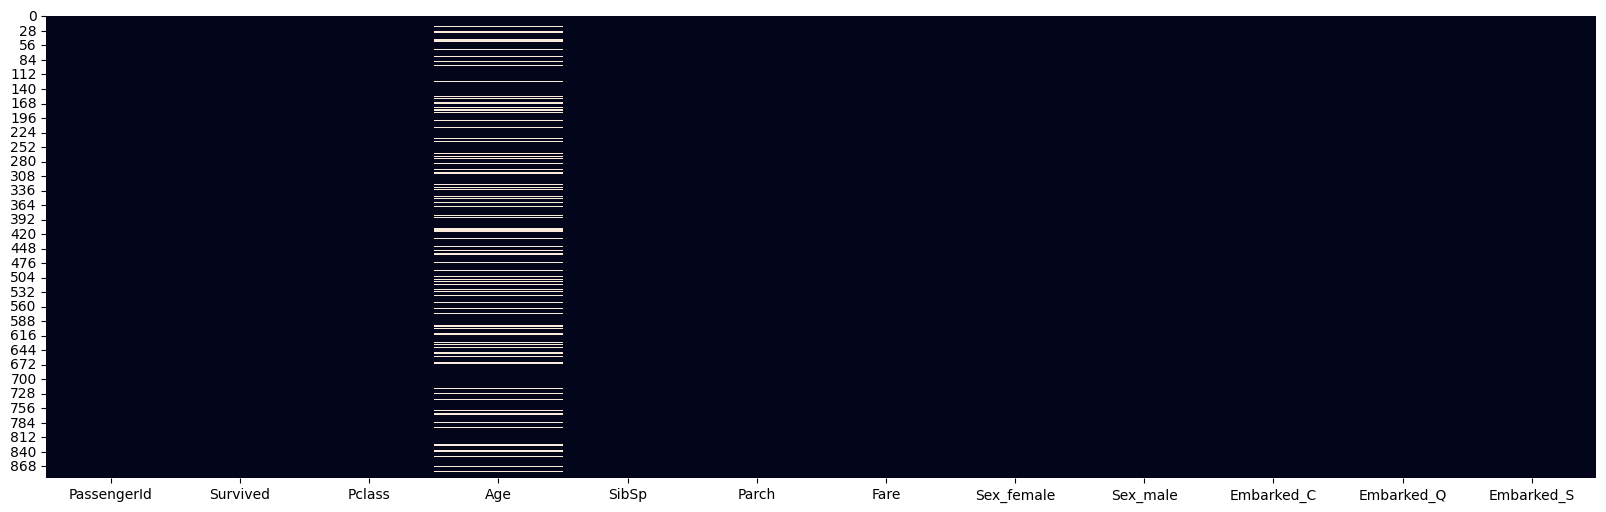

In [207]:
show_missing_values(train_df)

In [208]:
train_df = fill_missing_data_with_mice_imputer(train_df)

test_df = fill_missing_data_with_mice_imputer(test_df)

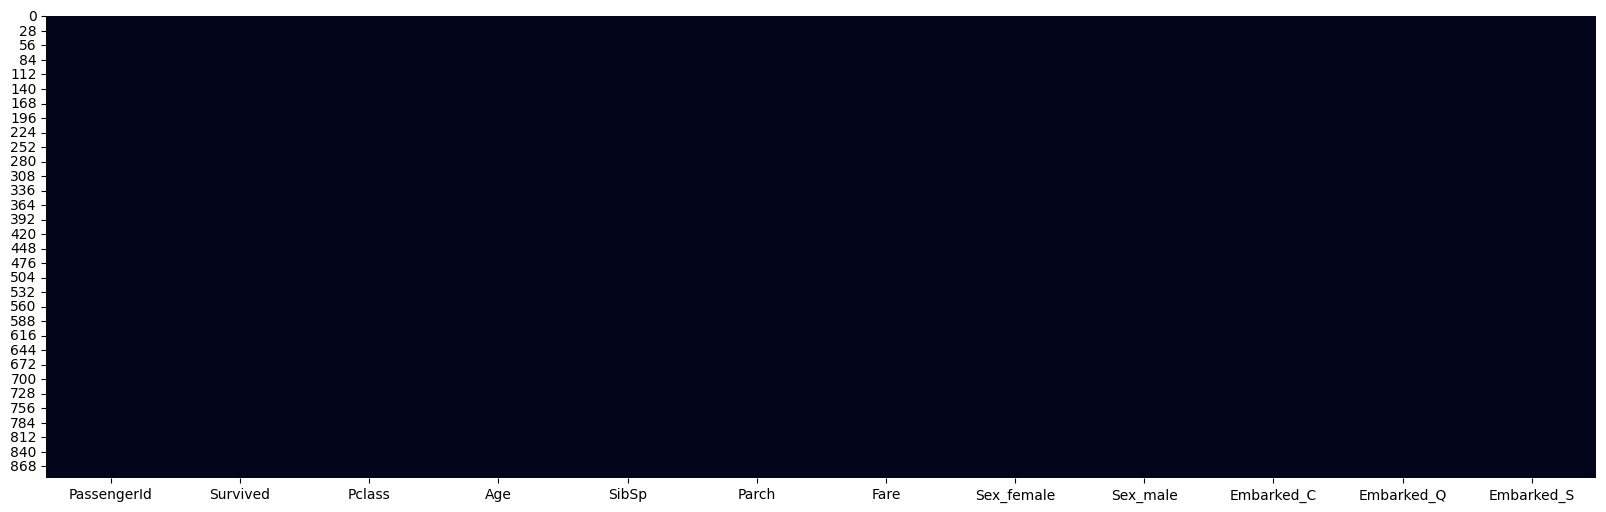

In [209]:
show_missing_values(train_df)

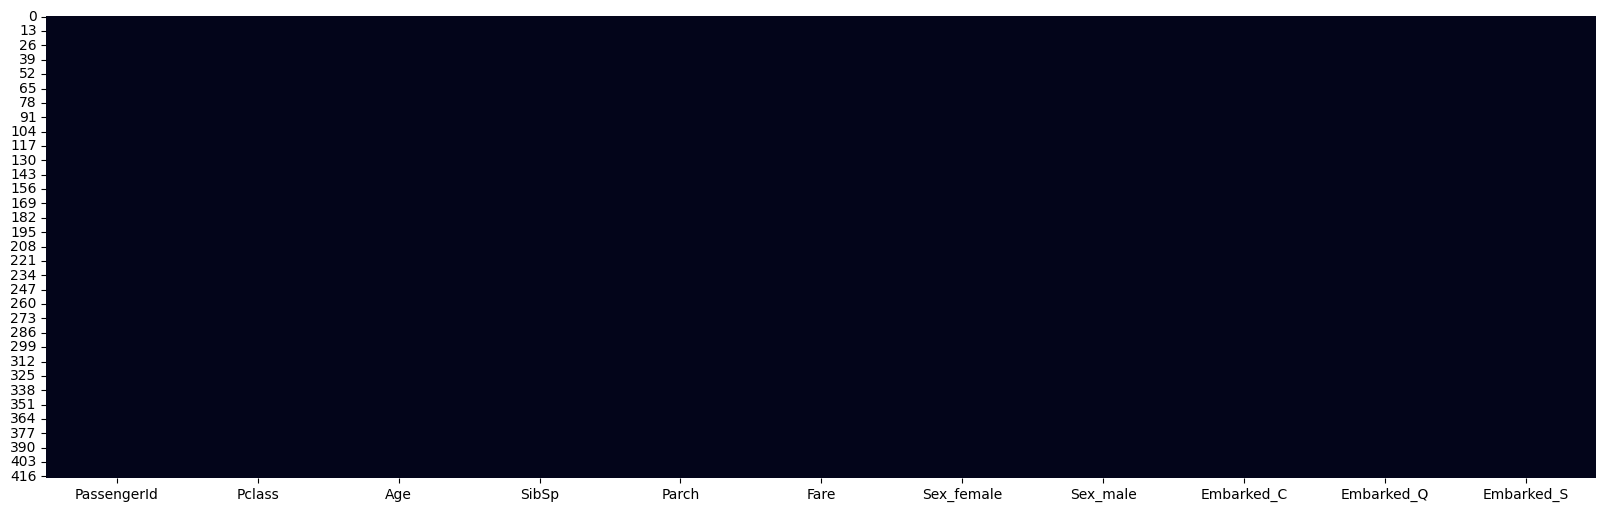

In [210]:
show_missing_values(test_df)

In [211]:
X = train_df.drop('Survived', axis=1)

y = train_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [212]:


def plot_results_for_model(hist, test_loss, test_acc, lr):
    """
    Plots the training history of a model, including loss and accuracy, and prints test results.

    Parameters:
    hist (History): The training history object returned by the fit method of a model.
    test_loss (float): The loss of the model on the test dataset.
    test_acc (float): The accuracy of the model on the test dataset.
    lr (float): The learning rate used in training the model.

    The function creates two subplots: one for the loss and one for the accuracy. It also prints
    out the learning rate, test accuracy, and test loss.
    """
    
    # Create a figure with two subplots horizontally aligned
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    # Divider line for better readability in console output
    print('---------------------------------------------------------\n' * 10)

    # Print learning rate, test accuracy, and test loss
    print('Learning rate:', lr)
    print('Test accuracy:', round(test_acc, 3), '%', 'Test loss:', round(test_loss, 3))

    # Plot training and validation loss
    ax[0].plot(hist.history['loss'], label='Model loss')
    ax[0].plot(hist.history['val_loss'], label='Val loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Calculate the number of epochs based on the accuracy history length
    epochs = len(hist.history['accuracy'])
    epochs_range = range(1, epochs + 1)

    # Plot training and validation accuracy
    ax[1].plot(epochs_range, hist.history['accuracy'][:epochs], label='Model accuracy')
    ax[1].plot(epochs_range, hist.history['val_accuracy'][:epochs], label='Val accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim(0, 1)  # Set the y-axis limit to range from 0 to 1
    ax[1].legend()

    # Display the plot
    plt.show()


In [213]:
def generate_results(model_results):
    highest_score = {}
    for model_lr, model_values in model_results.items():
        m_acc = model_values['accuracy']
        m_hist = model_values['history']
        m_loss = model_values['loss']
        model_obj = model_values['model']
       
        print(model_values)
        if 1.0 > m_acc > highest_score.get('accuracy',0) :
            highest_score =model_values
            highest_score['lr'] = model_lr
        plot_results_for_model(m_hist ,m_loss ,m_acc , model_lr)
   
        
    return highest_score
            

In [214]:
def train_model(learning_rate):
    from keras import Sequential


    
    
    inputs = keras.layers.Input(shape=(X.shape[1],))
    
    x = keras.layers.Dense(128, activation='relu')(inputs)
    
    x = keras.layers.Dense(64, activation='relu')(x)
    
    x = keras.layers.Dense(32, activation='relu')(x)
    
    
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    change_lr = keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.1)
    
    history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, change_lr])
    
     # Compile the model with Adam optimizer and binary crossentropy loss
  
    

    # Evaluate the trained model with the test data
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test accuracy with learning rate {learning_rate}: {test_acc}')

    # Print a summary of the model to understand its architecture
    print('Summary of model:')
    model.summary()
    
    # Return the training history, test accuracy, test loss, and the trained model
    return history, test_acc, test_loss, model
    




In [215]:

learning_rates = [0.0001, 0.001, 0.01, 0.1]

Epoch 1/1000
23/23 [==============================] - 1s 11ms/step - loss: 16.3998 - accuracy: 0.3764 - val_loss: 6.8437 - val_accuracy: 0.4134 - lr: 1.0000e-04
Epoch 2/1000
23/23 [==============================] - 0s 3ms/step - loss: 3.0936 - accuracy: 0.4579 - val_loss: 2.0517 - val_accuracy: 0.4804 - lr: 1.0000e-04
Epoch 3/1000
23/23 [==============================] - 0s 3ms/step - loss: 1.7620 - accuracy: 0.3624 - val_loss: 1.2945 - val_accuracy: 0.4302 - lr: 1.0000e-04
Epoch 4/1000
23/23 [==============================] - 0s 3ms/step - loss: 1.0562 - accuracy: 0.4747 - val_loss: 0.7453 - val_accuracy: 0.5698 - lr: 1.0000e-04
Epoch 5/1000
23/23 [==============================] - 0s 4ms/step - loss: 0.7147 - accuracy: 0.6096 - val_loss: 0.6434 - val_accuracy: 0.6536 - lr: 1.0000e-04
Epoch 6/1000
23/23 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.6404 - val_loss: 0.5862 - val_accuracy: 0.6983 - lr: 1.0000e-04
Epoch 7/1000
23/23 [========================

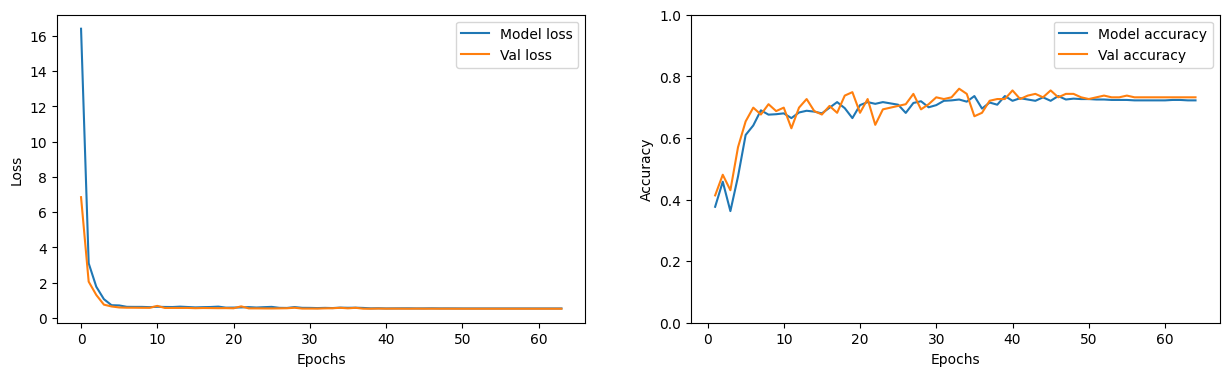

{'accuracy': 0.7932960987091064, 'loss': 0.4642687737941742, 'history': <keras.callbacks.History object at 0x00000191D1CD9310>, 'model': <keras.engine.functional.Functional object at 0x00000191CDDE3820>}
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------

Learning rate: 0.001
Test accuracy: 0.793 % Test loss: 0.464


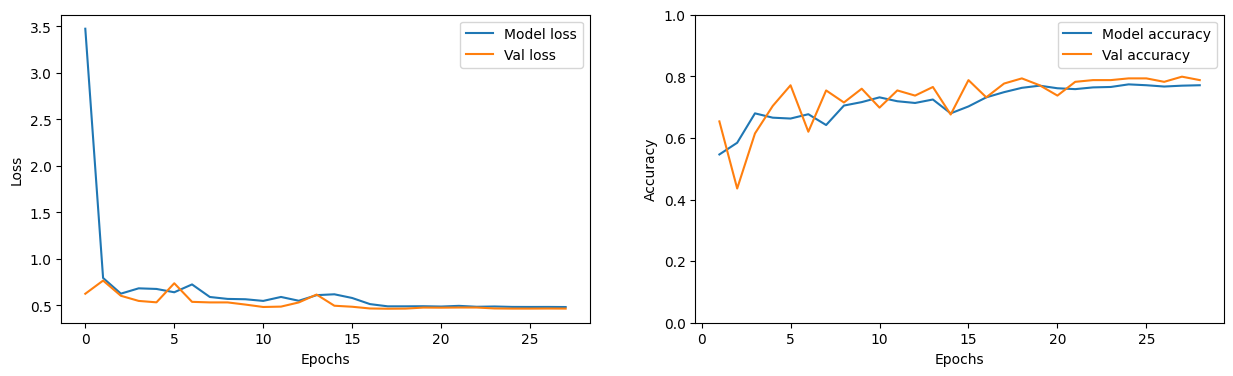

{'accuracy': 0.7988826632499695, 'loss': 0.4496096670627594, 'history': <keras.callbacks.History object at 0x00000191D2546BE0>, 'model': <keras.engine.functional.Functional object at 0x00000191D3E15A60>}
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------

Learning rate: 0.01
Test accuracy: 0.799 % Test loss: 0.45


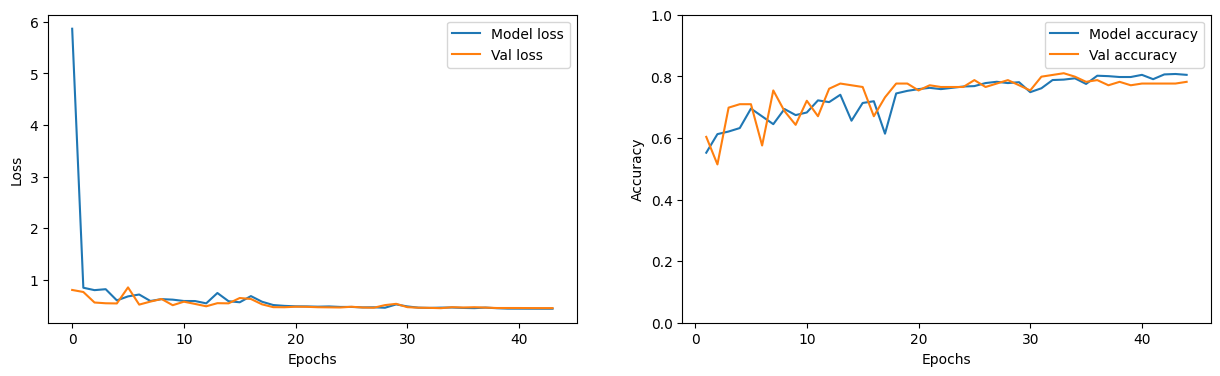

{'accuracy': 0.5865921974182129, 'loss': 0.6793597340583801, 'history': <keras.callbacks.History object at 0x00000191D8273400>, 'model': <keras.engine.functional.Functional object at 0x00000191D8176190>}
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------

Learning rate: 0.1
Test accuracy: 0.587 % Test loss: 0.679


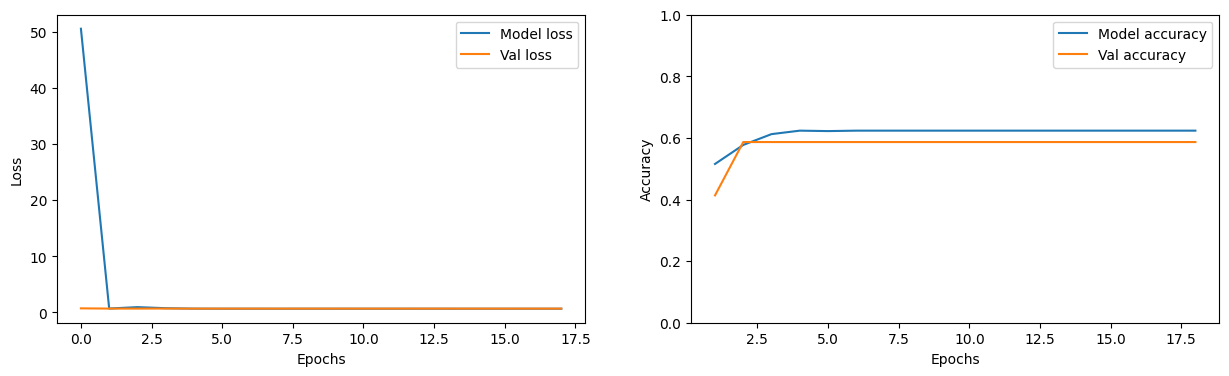

{'accuracy': 0.7988826632499695,
 'loss': 0.4496096670627594,
 'history': <keras.callbacks.History at 0x191d2546be0>,
 'model': <keras.engine.functional.Functional at 0x191d3e15a60>,
 'lr': 0.01}

In [216]:
# Train and evaluate the model for different learning rates
results = {}
for lr in learning_rates:
    history, accuracy , loss,model  = train_model(lr  )
    results[lr] = {'accuracy' :accuracy,
                   'loss':loss,
                   'history':history,
                   'model':model}
        
   
    
    
generate_results(results)
        
   
    
    

In [217]:

results


{0.0001: {'accuracy': 0.7318435907363892,
  'loss': 0.5149062871932983,
  'history': <keras.callbacks.History at 0x191cd88a280>,
  'model': <keras.engine.functional.Functional at 0x191cce80880>,
  'lr': 0.0001},
 0.001: {'accuracy': 0.7932960987091064,
  'loss': 0.4642687737941742,
  'history': <keras.callbacks.History at 0x191d1cd9310>,
  'model': <keras.engine.functional.Functional at 0x191cdde3820>,
  'lr': 0.001},
 0.01: {'accuracy': 0.7988826632499695,
  'loss': 0.4496096670627594,
  'history': <keras.callbacks.History at 0x191d2546be0>,
  'model': <keras.engine.functional.Functional at 0x191d3e15a60>,
  'lr': 0.01},
 0.1: {'accuracy': 0.5865921974182129,
  'loss': 0.6793597340583801,
  'history': <keras.callbacks.History at 0x191d8273400>,
  'model': <keras.engine.functional.Functional at 0x191d8176190>}}

In [218]:
# Show best accuracies


def show_best_accuracy(res):
    best_model = None
    print("Results:")
    for lr, vals in res.items():
        print(f'Learning Rate {lr}: Test Accuracy {vals["accuracy"]}')
        
    highest_accuracy = max([vals["accuracy"] for vals in res.values()])
    highest_accuracy_lr = [lr for lr, vals in res.items() if vals["accuracy"] == highest_accuracy][0]
    print(res[highest_accuracy_lr])
    best_model = res[highest_accuracy_lr]['model']
    print(f'Highest  Accuracy: {highest_accuracy} (Learning Rate {highest_accuracy_lr})')
    return best_model

In [219]:
best_model = show_best_accuracy(results)

Results:
Learning Rate 0.0001: Test Accuracy 0.7318435907363892
Learning Rate 0.001: Test Accuracy 0.7932960987091064
Learning Rate 0.01: Test Accuracy 0.7988826632499695
Learning Rate 0.1: Test Accuracy 0.5865921974182129
{'accuracy': 0.7988826632499695, 'loss': 0.4496096670627594, 'history': <keras.callbacks.History object at 0x00000191D2546BE0>, 'model': <keras.engine.functional.Functional object at 0x00000191D3E15A60>, 'lr': 0.01}
Highest  Accuracy: 0.7988826632499695 (Learning Rate 0.01)


In [220]:
X_train.columns, test_df.columns

(Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female',
        'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
       dtype='object'),
 Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female',
        'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
       dtype='object'))

In [221]:
submission_preds = best_model.predict(test_df)

14/14 [==============================] - 0s 1ms/step


In [222]:
submissions_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived':submission_preds.reshape(-1) })

In [223]:



submissions_df['PassengerId']  = submissions_df['PassengerId'].astype('int32')

submissions_df['Survived']  = submissions_df['Survived'].astype('int32')

submissions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int32
 1   Survived     418 non-null    int32
dtypes: int32(2)
memory usage: 3.4 KB


In [224]:
submissions_df.to_csv('./submissions/submission_3.csv', index=False)